In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import deltasigma as ds
import scipy as sp

C:\ProgramData\Anaconda3\lib\site-packages\deltasigma\__init__.py:919: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\ProgramDat

In [47]:
#Set Simulation Parameters
N = 8192*40;
t = np.arange(301)

#Set Modulator Parameters
x0=0
nlev=20
OSR = 128
order=2
optimizationFlag = 0

#Set Stagenumber
n = 5

"""
signal.ZerosPolesGain([1, 2], [3, 4], 5, dt=0.1)
ZerosPolesGainDiscrete(
array([1, 2]),
array([3, 4]),
5,
dt: 0.1
"""
#Create the Modulators
H = ds.synthesizeNTF(order,OSR,optimizationFlag)
#print(ds.pretty_lti(H))
[a,g,b,c] = ds.realizeNTF(H,'CIFF')
ABCD = ds.stuffABCD(a,g,b,c,form='CIFF')

#Create Known Modulator NTF (1-z^-1)^2
H2 = sp.signal.ZerosPolesGain([1, 1], [0, 0], 1)
[a,g,b,c] = ds.realizeNTF(H2,'CIFF');
ABCD2 = ds.stuffABCD(a,g,b,c,form='CIFF')
[NTF2,STF2] = ds.calculateTF(ABCD2)
print(ds.pretty_lti(STF2))
print(ds.pretty_lti(NTF2))

#Define input Signal
A = 3;
fB = int(np.ceil(N/(2.*OSR)))
ftest = np.floor(2./3.*fB)
u =A*np.sin(2*np.pi*ftest/N*np.arange(N))+2

#Create Y,V
[v,xn,xmax,y] = ds.simulateDSM(u,ABCD,nlev,x0);

"""
stage2=v-y
[v_2, xn_2, xmax_2, y_2] = ds.simulateDSM(stage2, ABCD, nlev, x0)
stage3=v_2-y_2
[v_3, xn_3, xmax_3, y_3] = ds.simulateDSM(stage3, ABCD, nlev, x0)
stage4=v_3-y_3
[v_4, xn_4, xmax_4, y_4] = ds.simulateDSM(stage4, ABCD, nlev, x0)
stage5=v_4-y_4
[v_5, xn_5, xmax_5, y_5] = ds.simulateDSM(stage5, ABCD, nlev, x0)
"""

#Create Y,V with NTF (1-z^-1)^2
[v21,xn21,xmax21,y21] = ds.simulateDSM(u,ABCD2,nlev,x0);
e = v21-y21
[v22,xn22,xmax22,y22] = ds.simulateDSM(e,ABCD2,nlev,x0);
#STF_tf = sp.signal.zpk2tf(STF2.zeros, STF2.poles, STF2.gain);
#NTF_tf = sp.signal.zpk2tf(NTF2.zeros, NTF2.poles, NTF2.gain);
#H21 = STF_tf; #H1*NTF = H2*STF; STF = 1; NTF = (1-z^-1)^2
#H22 = NTF_tf;
H22 = sp.signal.TransferFunction([1,-2,1],[1,0,0]);
print(ds.pretty_lti(H21.to_zpk()))
H21 = sp.signal.TransferFunction([1],[1]);

filtered_v21 = sp.signal.lfilter(H21.num,H21.den,v21);
filtered_v22 = sp.signal.lfilter(H22.num,H22.den,v22);
vfinalM22 = filtered_v21 - filtered_v22;

vout = vfinalM22;


C:\ProgramData\Anaconda3\lib\site-packages\deltasigma\_realizeNTF.py:223: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T


1
 (z - 1)^2 
-----------
    z^2    
 (z - 1)^2 
-----------
    z^2    


[1.80358108e-06 5.41074324e-06 5.41074324e-06 1.80358108e-06] [ 1.         -2.95091385  2.90302503 -0.95209675]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


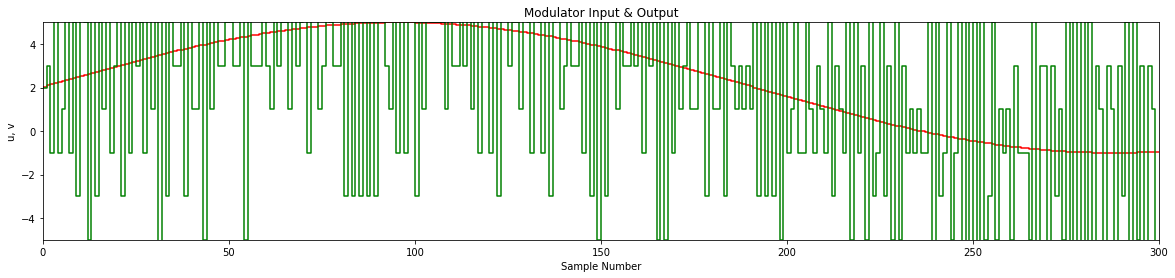

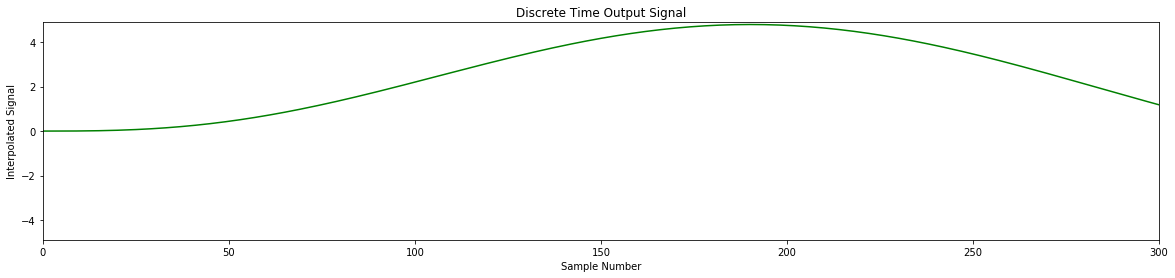

'\nProblems\n1 Very Small output after Butterworth Filter\n2 Lfilter: Digital or Analog?\n3 Retrieval of Signal in MASH\n4 Retrieval in Modulator - correct? Cutoff Frequency\n'

In [48]:
from scipy.signal import butter, lfilter
from scipy.signal import freqs

#Create Butterworth Transfer Function
slack = 1;
order = 3; fc = 1./OSR*slack;
btype = 'lowpass'; analog = 'False'; output = 'ba';

num,den = butter(order,fc,btype,analog,output);
num,den = butter(order,fc);
print(num,den)

#Filter V
U_bar = lfilter(num,den,vout);

#Plot U,V
plt.figure(figsize=(20, 4))
plt.step(t, u[t],'r')
plt.hold(True)
plt.step(t, vout[t], 'g')
plt.axis([0, 300, -u.max(), u.max()])
plt.xlabel('Sample Number')
plt.ylabel('u, v')
plt.title('Modulator Input & Output');
plt.show()

#Plot Interpolated Signal
plt.figure(figsize=(20, 4))
plt.plot(t, U_bar[t], 'g')
plt.axis([0, 300,-U_bar.max(),U_bar.max()])
plt.xlabel('Sample Number')
plt.ylabel('Interpolated Signal')
plt.title('Discrete Time Output Signal');
plt.show()


"""
Problems
1 Very Small output after Butterworth Filter
2 Lfilter: Digital or Analog?
3 Retrieval of Signal in MASH
4 Retrieval in Modulator - correct? Cutoff Frequency
"""

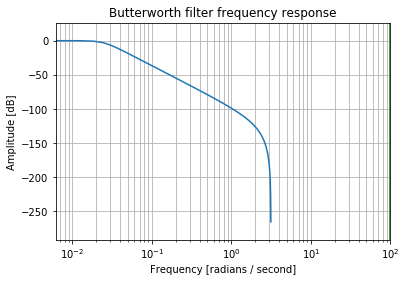

In [49]:
import scipy.signal as signal
w, h = signal.freqz(num, den)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()